# Starting position analysis

**Background**

Within the player community, there is some suspicion that the starting position impacts the overall win percentage. The majority opinion appears to be that the player in the first seat holds an advantage due to tempo - they will have played an extra turn when evaluating event cards most of the time. Conversely, downstream players have a disadvantage attacking players earlier in player order as they will have an extra turn to develop their strength.

Players later in turn order do observe some advantages - bonus civil actions on the first round, the ability to react to the turns of upstream players, and finally to optimize age 3 impacts.

**Summary of report**

[Data transformation](#Read-and-transform-the-data.) - In this section we load the data and curate two dataframes:
- results_by_player_with_rating_df: maps each (player, game_id) tuple to the outcome, seating, game information, and glicko2 ratings.
- subgames_df: splits each game into 3, one for each combination of pairs within the 3 players, with information about the outcomes and ratings of each participating player.

[Data exploration](#Explore-the-data.) - In this section we explore the data through visualizations and examining distributions.

[Effect of seating on submatches](#Effect-of-seating-on-submatches.) - In this section we split each three-player match into three individual matches, one for each pair of players. We estimate the effect of seating on the outcome for each of the three seating pairs, controlling for player skill. We perform a logistic regression of the outcome on the difference in player skill, and test the hypothesis that $\beta_0\ne0$ for each submatch. This allows us to build some intuition for the more complicated three-player match.

[Effect of seating on match](#Effect-of-seating-on-match-outcome.) - In this section, we perform a logistic regression of the outcome on the differences in player skill between both opponents and the seating.

We note that by creating three observations for each match, we are creating a model on correlated data (e.g. if seat 1 beats seat 2 and seat 2 beats seat 3, seat 1 by definition beats seat 3). The resulting model underestimates the true variance, and serves as a lower-bound on the p-value.

**Conclusions**

Examining the submatches, we were unable to find significant evidence that player seating impacts the expected outcome, controlling for the skill difference between players. We find each rating point advantage corresponds to a $~0.0045$ increase in the log odds of winning. We were also unable to evidence that player seating impacts the expected outcome of the three-player match, and that the minimum difference (e.g. the smallest advantage in rating between both opponents) has the highest impact in predicting the outcome.

When fitting the outcome of a match for each player, we find the seating has a small to no impact on the win probability. In addition, we find that the minimum skill difference between the two opponents impacts the log-odds to win much moreso than the maximum skill difference.

We remove games with new players, as their rating is unknown. This biases this study towards higher divisions (most new players are in the bottom two divisions), and generally towards higher skill games.

An additional open question is how to optimize the rating calculation as to best predict the outcome of a game.

**Acknowledgements**

Thanks to Pavel Ceska for organizing these great tournaments and providing the data, and to Parker Trostle for discussions on the statistical analysis.

In [1]:
import datetime as dt
import functools
import warnings

import pandas as pd
import plotnine
import statsmodels.formula.api as smf

# Local module used to ergonimically return data.
import fetch

warnings.filterwarnings("ignore")

In [2]:
# Parameters
# The initial rating and initial deviation values are used to
# estimate strength of new players.

initial_rating = 1500
initial_deviation = 150

## Read and transform the data.

Load the `game_results_by_player` view and enrich with conservative glicko-2 ratings. A follow up study would examine the effect of using the conservative rating.

For each game - extract the 3 player-player combinations to approximate the game as a combination of 3 separate matches. This approximation introduces dependence within the submatches.

In [3]:
# Load the view mapping (season, division, game_id, player): (points, finish, position)
# Where position is the starting position.

results_by_player_df = (
    fetch.view(node="game_results_by_player")
    .as_pandas()
)

historical_ratings_complete_df = (
    fetch.data_source(node="historical_ratings_complete")
    .as_pandas(header=1)
)

### Attributes by player and game

Construct a dataframe mapping the rating of each player prior to the tournament.

For season 8 we use the ratings assigned in Sept 2020, and for season 9 we use the ratings assigned in Dec 2020.

The final output is rating and division information for each (player, game_id) combination.

In [4]:
# Load in the data with updated column names.
months = [
    dt.datetime(2021, 3, 1),
    dt.datetime(2020, 12, 1),
    dt.datetime(2020, 9, 1),
    dt.datetime(2020, 6, 1),
    dt.datetime(2020, 3, 1),
    dt.datetime(2019, 12, 1),
    dt.datetime(2019, 9, 1),
    dt.datetime(2019, 6, 1),
    dt.datetime(2019, 3, 1),
    dt.datetime(2018, 12, 1),
    dt.datetime(2018, 9, 1),
    dt.datetime(2018, 6, 1),
    dt.datetime(2018, 3, 1),
    dt.datetime(2017, 12, 1)
]

new_column_names = (
    ["name", "n_opponents"]
    + [
        f"{month.strftime('%b-%Y')}_{col}"
        for month in months
        for col in ["estimated", "conservative", "rank"]
    ]
)

historical_ratings_complete_renamed_df = functools.reduce(
    lambda df, cols: (
        df
        .assign(**{cols[0]: df[cols[1]]})
        .drop(cols[1], axis=1)
    ),
    zip(new_column_names, historical_ratings_complete_df.columns),
    historical_ratings_complete_df
)

month_cols = [f"{month.strftime('%b-%Y')}" for month in months]

# Concatenate the estimated and conservative glicko2 ratings into
# a single column to melt the dataframe.
historical_ratings_complete_compacted_df = functools.reduce(
    lambda df, month_col: df.assign(
        **{
            f"{month_col}": (
                historical_ratings_complete_renamed_df
                [[f"{month_col}_estimated", f"{month_col}_conservative"]]
                .values
                .tolist()
            )
        }
    ),
    month_cols,
    historical_ratings_complete_renamed_df
)

def month_year_to_date(d) -> dt.datetime:
    return dt.datetime.strptime(d, "%b-%Y")

player_ratings_by_month_df = (
    pd.melt(
        historical_ratings_complete_compacted_df,
        id_vars=["name"],
        value_vars=month_cols,
        var_name="month",
        value_name="ratings"
    )
    .assign(estimated=lambda df: df.ratings.apply(lambda x: x[0]))
    .assign(conservative=lambda df: df.ratings.apply(lambda x: x[1]))
    .assign(date=lambda df: df.month.apply(month_year_to_date))
    .assign(player=lambda df: df.name)
    [["player", "date", "estimated", "conservative"]]
)

# Map the rating dates to tournament season.

player_ratings_season_8_9_df = pd.concat(
    (
        (
            player_ratings_by_month_df
            .query(f"date == '{rating_date}'")
            .assign(season=season)
        )
        for rating_date, season in (
            ("2020-09-01", 8),
            ("2020-12-01", 9)
        )
    )
)

results_by_player_with_rating_df = (
    results_by_player_df
    .merge(
        player_ratings_season_8_9_df,
        on=["season", "player"],
        how="left"
    )
)

### Games by seating pair

To investigate the effect of seating arrangement on the resutls, we split each game into three subgames:
- seat 1 vs. seat 2
- seat 1 vs. seat 3
- seat 2 vs. seat 3

And investigate the hypothesis that, accounting for skill with estimated rating, that the base win percentage between all seats is 0.5. 

In [5]:
def split_games(df: pd.DataFrame):
    first_seat = df[df.position==1].iloc[0]
    second_seat = df[df.position==2].iloc[0]
    third_seat = df[df.position==3].iloc[0]
    
    return pd.DataFrame(
        (
            {
                "upstream_seat": upstream_seat,
                "downstream_seat": downstream_seat,
                "outcome": int(upstream.points > downstream.points),
                "upstream_points": upstream.points,
                "downstream_points": downstream.points,
                "upstream_estimated": upstream.estimated,
                "downstream_estimated": downstream.estimated,
                "upstream_conservative": upstream.conservative,
                "downstream_conservative": downstream.conservative,
                "one_new": upstream.no_rating | downstream.no_rating,
                "both_new": upstream.no_rating & downstream.no_rating
            }
            for upstream_seat, downstream_seat, upstream, downstream in (
                (1, 2, first_seat, second_seat),
                (1, 3, first_seat, third_seat),
                (2, 3, second_seat, third_seat)
            )
        )
    )

In [6]:
# Create 3 records for each game-id, one for each 'sub-game'.

subgames_df = (
    results_by_player_with_rating_df
    .assign(no_rating=lambda df: df.estimated.isnull())
    .fillna({"estimated": initial_rating})
    .fillna({"conservative": initial_rating - 3 * initial_deviation})
    .groupby(["season", "division", "game_id"])
    .apply(split_games)
    .reset_index()
    .assign(estimated_diff=lambda df: df.upstream_estimated - df.downstream_estimated)
    .drop("level_3", axis=1)
)

### Games by seat

In [7]:
def collect_games(df: pd.DataFrame):
    first_seat = df[df.position==1].iloc[0]
    second_seat = df[df.position==2].iloc[0]
    third_seat = df[df.position==3].iloc[0]
    
    return pd.DataFrame(
        (
            {
                "seat": seat,
                "rating": player.estimated,
                "points": player.points,
                "outcome": int(
                    (player.points > opponent_1.points)
                    & (player.points > opponent_2.points)
                ),
                "max_advantage": max(
                    player.estimated - opponent_1.estimated,
                    player.estimated - opponent_2.estimated
                ),
                "min_advantage": min(
                    player.estimated - opponent_1.estimated,
                    player.estimated - opponent_2.estimated
                ),
                "one_new": any(
                    (player.no_rating, opponent_1.no_rating, opponent_2.no_rating)
                ),
                "all_new": all(
                    (player.no_rating, opponent_1.no_rating, opponent_2.no_rating)
                )
            }
            for seat, player, opponent_1, opponent_2 in (
                (1, first_seat, second_seat, third_seat),
                (2, second_seat, first_seat, third_seat),
                (3, third_seat, first_seat, second_seat)
            )
        )
    )

In [8]:
# Create 3 records for each game-id, one for each 'sub-game'.

games_df = (
    results_by_player_with_rating_df
    .assign(no_rating=lambda df: df.estimated.isnull())
    .fillna({"estimated": initial_rating})
    .fillna({"conservative": initial_rating - 3 * initial_deviation})
    .groupby(["season", "division", "game_id"])
    .apply(collect_games)
    .reset_index()
    .drop("level_3", axis=1)
)

## Explore the data.

In this section we visualize the data in a variety of ways to both gain an intuition for the main question at hand (is seating a significant factor in predicting the winner of a match), as well as answer some unrelated questions, (e.g. how has the tournament grown over time).

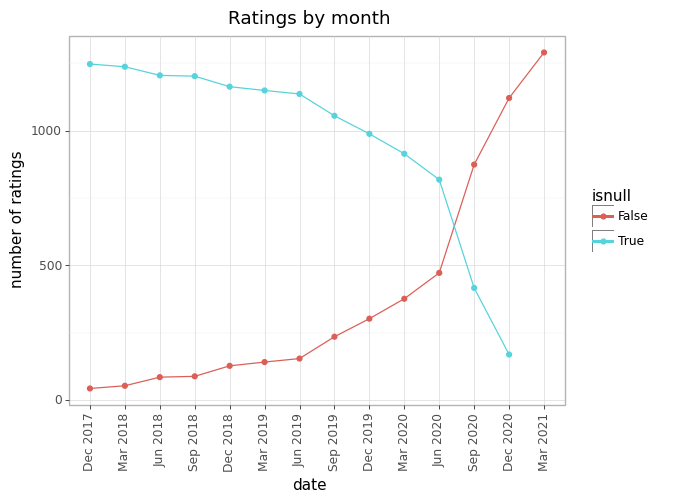

In [9]:
(
    plotnine.ggplot(
        player_ratings_by_month_df
        .assign(isnull=lambda df: df.estimated.isnull())
        .groupby(["date", "isnull"])
        .agg(count=("player", "count"))
        .reset_index()
        .sort_values("date")
        .assign(
            date_str=lambda df: pd.Categorical(
                df.date.apply(lambda d: d.strftime("%b %Y")),
                categories=(df.date.apply(lambda d: d.strftime("%b %Y")).unique())
            )
        )
    )
    + plotnine.aes(x="date_str", y="count", group="isnull", color="isnull")
    + plotnine.geom_point()
    + plotnine.geom_line()
    + plotnine.theme_light()
    + plotnine.theme(axis_text_x=plotnine.element_text(angle=90))
    + plotnine.labs(
        title="Ratings by month",
        x="date",
        y="number of ratings"
    )
).draw();

**Figure** - Ratings by player over time. We see that the number of players rated increased drastically since June 2020. We confirmed with the organizer that this is when CGE (the developer of the game) released official tournament support, leading to a surge in tournament participation. Player ratings lag behind actual participation, as initial ratings are assigned after a player's first tournament.

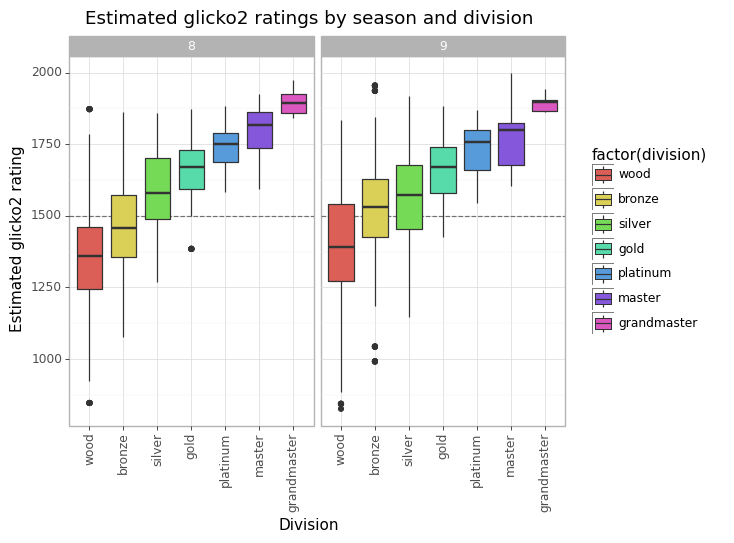

In [10]:
(
    plotnine.ggplot(
        results_by_player_with_rating_df
        [~results_by_player_with_rating_df.estimated.isnull()]
    )
    + plotnine.geom_hline(yintercept=initial_rating, linetype="dashed", alpha=0.5)
    + plotnine.aes(
        x="division",
        y="estimated",
        group="factor(division)",
        fill="factor(division)"
    )
    + plotnine.geom_boxplot()
    + plotnine.facet_wrap("~season")
    + plotnine.theme_light()
    + plotnine.theme(axis_text_x=plotnine.element_text(angle=90, vjust=1, hjust=0.5))
    + plotnine.labs(
        title="Estimated glicko2 ratings by season and division",
        x="Division",
        y="Estimated glicko2 rating",
        color="Division"
    )
).draw();

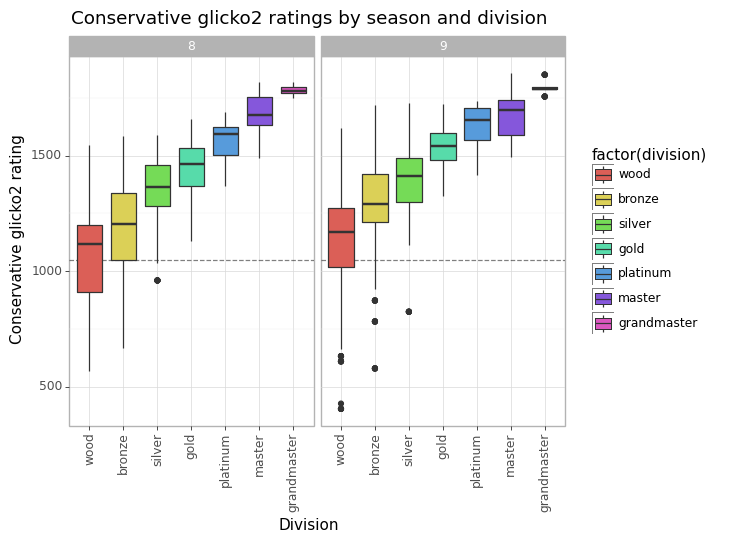

In [11]:
(
    plotnine.ggplot(
        results_by_player_with_rating_df
        [~results_by_player_with_rating_df.estimated.isnull()]
    )
    + plotnine.geom_hline(yintercept=1500-150*3, linetype="dashed", alpha=0.5)
    + plotnine.aes(
        x="division",
        y="conservative",
        group="factor(division)",
        fill="factor(division)"
    )
    + plotnine.geom_boxplot()
    + plotnine.facet_wrap("~season")
    + plotnine.theme_light()
    + plotnine.theme(axis_text_x=plotnine.element_text(angle=90, vjust=1, hjust=0.5))
    + plotnine.labs(
        title="Conservative glicko2 ratings by season and division",
        x="Division",
        y="Conservative glicko2 rating",
        color="Division"
    )
).draw();

## Effect of seating on submatches.

In this section we split each game into 3 subgames, player 1 vs. player 2, player 1 vs. player 3, and player 2 vs. player 3.

We regress the outcome (upstream player wins) against the difference in skill between the upstream player and downstream player, using a linear logistic regression:
$$\log\left(\frac{p(x)}{1-p(x)}\right)=\beta_0+\beta_1x,$$

where x is the rating advantage of the upstream player, and p(x) is the probability that the upstream player wins.

We can test the hypothesis that either the upstream player or downstream player enjoy an inherent advantage ($b_0 \ne 0$)for all submatches. Since we have multiple (3) observations, we can use the Bonferroni correction to set our significance level per observation at $\alpha^\prime\simeq0.167.$

More formally, we test the hypotheses:
$$H_0: \beta_{12, 0}=\beta_{13, 0}=\beta_{23, 0}$$
$$H_A: \bigcup_{s\in\{12, 13, 23\}}\beta_{s,0}\ne0,$$

where $\beta_{ij, 0}$ is the estimated intercept of the logistic regression fit for seat $i$ (upstream) vs. seat $j$ (downstream).

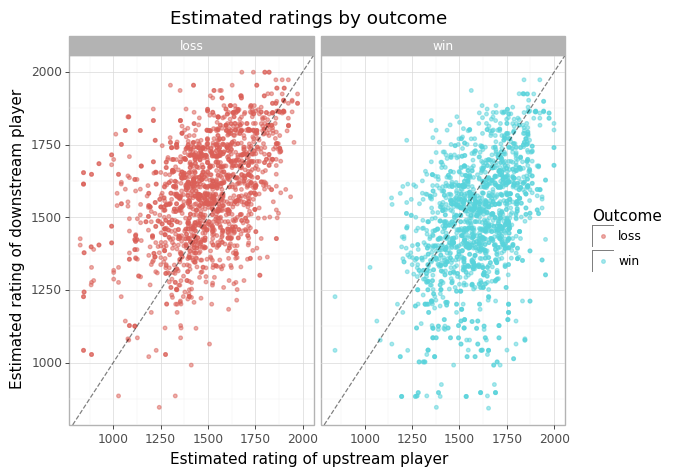

In [13]:
(
    plotnine.ggplot(
        subgames_df
        [~subgames_df.one_new]
        .assign(outcome=lambda df: df.outcome.apply(lambda x: "win" if x else "loss"))
    )
    + plotnine.aes(x="upstream_estimated", y="downstream_estimated", group="factor(outcome)", color="factor(outcome)")
    + plotnine.geom_point(alpha=0.5, size=1)
    + plotnine.facet_wrap("~outcome")
    + plotnine.geom_abline(intercept=0, slope=1, linetype="dashed", alpha=0.5)
    + plotnine.theme_light()
    + plotnine.labs(
        title="Estimated ratings by outcome",
        x="Estimated rating of upstream player",
        y="Estimated rating of downstream player",
        color="Outcome"
    )
).draw();

**Figure** - Outcome from the perspective of the upstream player by estimated glicko2 ratings. The dashed line shows where the two players have equal rating. We see by eye that (unsurprisingly) the upstream player tends to win when their rating is higher than the downstream player. We also note that the distributions seem well described by bivariate Gaussians.

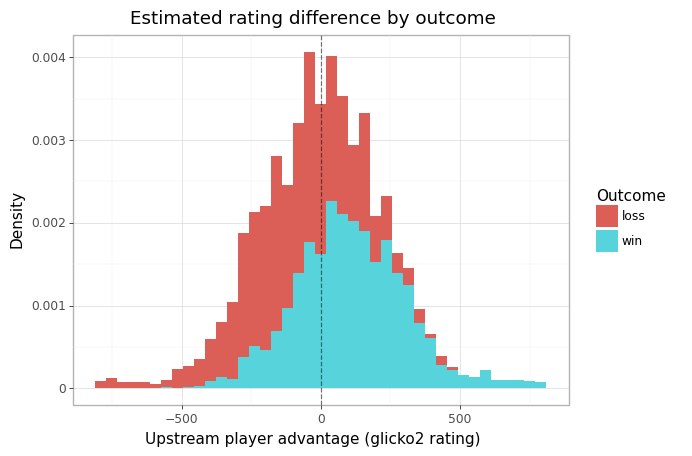

In [14]:
(
    plotnine.ggplot(
        subgames_df
        [~subgames_df.one_new]
        .assign(outcome=lambda df: df.outcome.apply(lambda x: "win" if x else "loss"))
        .assign(rating_diff=lambda df: df.upstream_estimated - df.downstream_estimated)
    )
    + plotnine.aes(x="rating_diff", y="..density..", group="factor(outcome)", fill="factor(outcome)")
    + plotnine.geom_histogram()
    + plotnine.geom_vline(xintercept=0, linetype="dashed", alpha=0.5)
    + plotnine.theme_light()
    + plotnine.labs(
        title="Estimated rating difference by outcome",
        x="Upstream player advantage (glicko2 rating)",
        y="Density",
        fill="Outcome"
    )
).draw();

**Figure** - Outcomes by upstream player advantage, defined as the difference in estimated glicko2 rating between the upstream player and downstream player. We see by eye that the fraction of games won increases with the rating advantage.

In [15]:
# Split the subgames dataframe into 3 dataframes, each one focusing
# on a specific subgame.

seat12_df, seat13_df, seat23_df = (
    subgames_df
    [
        (subgames_df.upstream_seat == upstream_seat)
        & (subgames_df.downstream_seat == downstream_seat)
    ]
    for upstream_seat, downstream_seat in (
        (1, 2),
        (1, 3),
        (2, 3)
    )
)

In [16]:
model12, model13, model23 = (
    smf.logit("outcome~estimated_diff", data=data).fit()
    for data in (seat12_df, seat13_df, seat23_df)
)

Optimization terminated successfully.
         Current function value: 0.616146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609450
         Iterations 5


In [17]:
print(model12.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 1752
Model:                          Logit   Df Residuals:                     1750
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                  0.1105
Time:                        12:34:49   Log-Likelihood:                -1079.5
converged:                       True   LL-Null:                       -1213.6
Covariance Type:            nonrobust   LLR p-value:                 2.707e-60
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1072      0.052     -2.071      0.038      -0.209      -0.006
estimated_diff     0.0043      0.000     14.383      0.000       0.004       0.005


In [18]:
print(model13.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 1752
Model:                          Logit   Df Residuals:                     1750
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                  0.1231
Time:                        12:34:49   Log-Likelihood:                -1064.9
converged:                       True   LL-Null:                       -1214.3
Covariance Type:            nonrobust   LLR p-value:                 5.839e-67
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0289      0.052     -0.554      0.580      -0.131       0.073
estimated_diff     0.0047      0.000     14.961      0.000       0.004       0.005


In [19]:
print(model23.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 1752
Model:                          Logit   Df Residuals:                     1750
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                  0.1207
Time:                        12:34:49   Log-Likelihood:                -1067.8
converged:                       True   LL-Null:                       -1214.4
Covariance Type:            nonrobust   LLR p-value:                 9.799e-66
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0118      0.052      0.227      0.820      -0.090       0.114
estimated_diff     0.0046      0.000     14.905      0.000       0.004       0.005


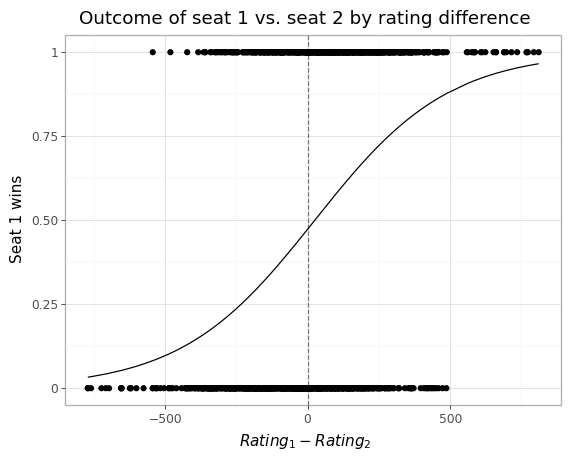

In [20]:
(
    plotnine.ggplot(seat12_df.assign(fit=model12.predict(seat12_df[["estimated_diff"]])))
    + plotnine.aes(x="estimated_diff", y="outcome")
    + plotnine.geom_point()
    + plotnine.geom_line(plotnine.aes(y="fit"))
    + plotnine.geom_vline(xintercept=0., linetype="dashed", alpha=0.5)
    + plotnine.theme_light()
    + plotnine.labs(
        title="Outcome of seat 1 vs. seat 2 by rating difference",
        x=r"$Rating_{1} - Rating_{2}$",
        y="Seat 1 wins"
    )
).draw();

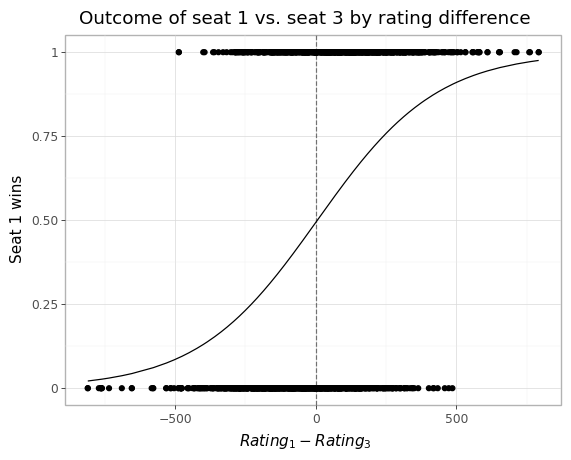

In [21]:
(
    plotnine.ggplot(seat13_df.assign(fit=model13.predict(seat13_df[["estimated_diff"]])))
    + plotnine.aes(x="estimated_diff", y="outcome")
    + plotnine.geom_point()
    + plotnine.geom_line(plotnine.aes(y="fit"))
    + plotnine.geom_vline(xintercept=0., linetype="dashed", alpha=0.5)
    + plotnine.theme_light()
    + plotnine.labs(
        title="Outcome of seat 1 vs. seat 3 by rating difference",
        x=r"$Rating_{1} - Rating_{3}$",
        y="Seat 1 wins"
    )
).draw();

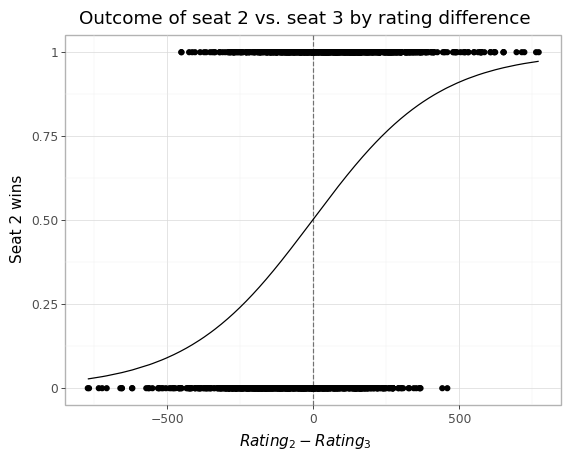

In [22]:
(
    plotnine.ggplot(seat23_df.assign(fit=model23.predict(seat23_df[["estimated_diff"]])))
    + plotnine.aes(x="estimated_diff", y="outcome")
    + plotnine.geom_point()
    + plotnine.geom_line(plotnine.aes(y="fit"))
    + plotnine.theme_light()
    + plotnine.geom_vline(xintercept=0., linetype="dashed", alpha=0.5)
    + plotnine.labs(
        title="Outcome of seat 2 vs. seat 3 by rating difference",
        x=r"$Rating_{2} - Rating_{3}$",
        y="Seat 2 wins"
    )
).draw();

**Conclusions** - When breaking down each match into 3 individual matches, we do not find enough evidence to overturn the null hypothesis that the seating has a significant impact on the outcome. The fit model estimates each point increase in rating increases the log odds of winning by ~0.0045.

By eye, we see that the probability of the upstream player winning with a rating difference of 0 is roughly the no-information expected value of winning (1/2).

## Effect of seating match outcome.

In this section we determine the effect of seating on the outcome of the 3p game. We one-hot encode the seating and perform a logistic regression on the outcome by both minimum and maximum advantage as well as the seating. Each match produces three dependent observations (the outcome experienced by each player), and the model underestimates the variance, and p-value.

More formally, we test the hypotheses:
$$H_0: \beta_{seat_1}=\beta_{seat_2}=\beta_{seat_3}$$
$$H_A: \bigcup_{s\in\{1, 2, 3\}}\beta_{seat_i}\ne0,$$

where $\beta_{seat_i}$ is the model's estimated coefficient for a player in seat i.

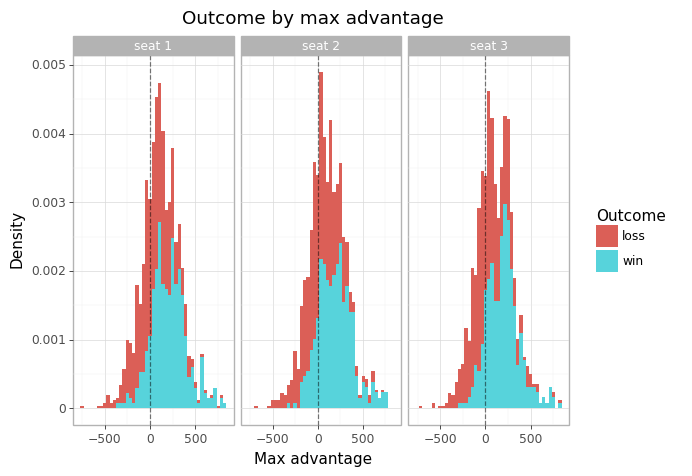

In [23]:
(
    plotnine.ggplot(
        games_df
        [~games_df.one_new]
        .assign(outcome=lambda df: df.outcome.apply(lambda x: "win" if x else "loss"))
        .assign(seat=lambda df: df.seat.apply(lambda x: f"seat {x}"))
    )
    + plotnine.aes(x="max_advantage", y="..density..", group="factor(outcome)", fill="factor(outcome)")
    + plotnine.geom_histogram()
    + plotnine.geom_vline(xintercept=0, linetype="dashed", alpha=0.5)
    + plotnine.facet_wrap("~seat")
    + plotnine.theme_light()
    + plotnine.labs(
        title="Outcome by max advantage",
        x="Max advantage",
        y="Density",
        fill="Outcome"
    )
).draw();

**Figure** - Distribution of maximum rating difference relative to both opponents, split by outcome and seating. We observe the same general trend across seating - wins are more likely at larger advantages. The center of the distribution is greater than zero as we are taking the maximum of two values.

We filter out games where there is a new player, as their rating is unknown.

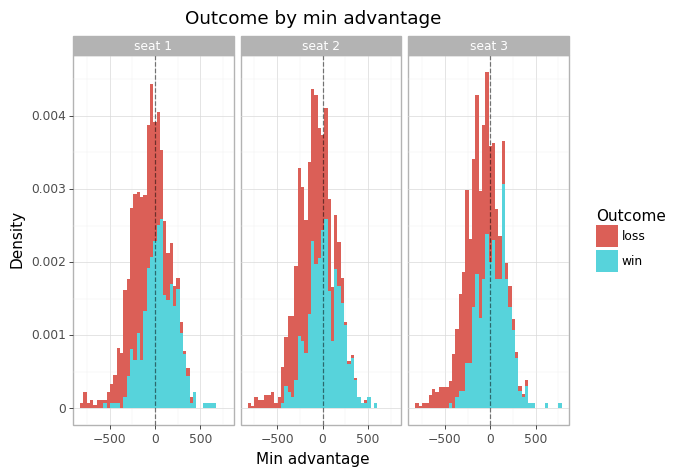

In [24]:
(
    plotnine.ggplot(
        games_df
        [~games_df.one_new]
        .assign(outcome=lambda df: df.outcome.apply(lambda x: "win" if x else "loss"))
        .assign(seat=lambda df: df.seat.apply(lambda x: f"seat {x}"))
    )
    + plotnine.aes(x="min_advantage", y="..density..", group="factor(outcome)", fill="factor(outcome)")
    + plotnine.geom_histogram()
    + plotnine.geom_vline(xintercept=0, linetype="dashed", alpha=0.5)
    + plotnine.facet_wrap("~seat")
    + plotnine.theme_light()
    + plotnine.labs(
        title="Outcome by min advantage",
        x="Min advantage",
        y="Density",
        fill="Outcome"
    )
).draw();

**Figure** - Distribution of minimum rating difference relative to both opponents, split by outcome and seating. We observe the same general trend across seating - wins are more likely at larger advantages. The center of the distribution is less than zero as we are taking the minimum of two values.

Compared to the previous figure, showing the distribution of maximum differences, we note that there are less losses at extreme advantages (>500) and less wins at extreme disadvantages (-500). Intuitively we expect the minimum difference in estimated skill to play a larger impact than the maximum difference.

We filter out games where there is a new player, as their rating is unknown.

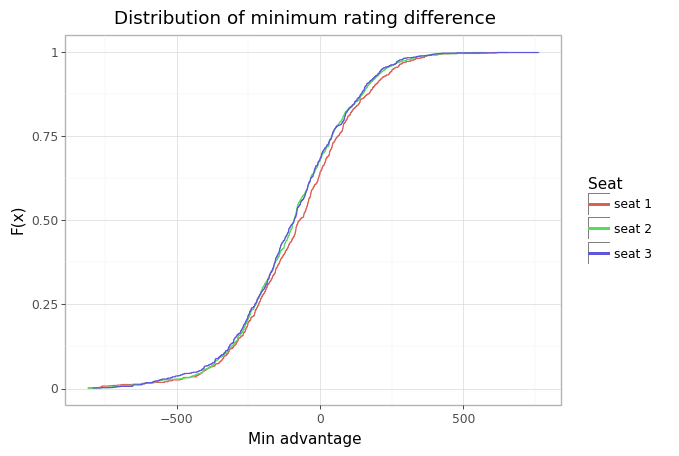

In [25]:
(
    plotnine.ggplot(
        games_df
        [~games_df.one_new]
        .assign(outcome=lambda df: df.outcome.apply(lambda x: "win" if x else "loss"))
        .assign(seat=lambda df: df.seat.apply(lambda x: f"seat {x}"))
    )
    + plotnine.aes(x="min_advantage", group="factor(seat)", color="factor(seat)")
    + plotnine.stat_ecdf()
    + plotnine.theme_light()
    + plotnine.labs(
        title="Distribution of minimum rating difference",
        x="Min advantage",
        y="F(x)",
        color="Seat"
    )
).draw();

**Figure** - We examine the distribution of minimum advantage by seat, and note that players in seat 1 tend to have a higher estimated skill compared to the other two seats. This could lead to overestimating the impact of being in seat 1 if player skill is not taken into account.

In [26]:
encoded_games_df = (
    pd.get_dummies(games_df, prefix="seat", columns=["seat"])
    .assign(seat=games_df.seat)
)

model = (
    smf.logit(
        "outcome~max_advantage+min_advantage+seat_1+seat_2+seat_3",
        data=encoded_games_df
    )
    .fit()
)

Optimization terminated successfully.
         Current function value: 0.561732
         Iterations 6


In [27]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 5256
Model:                          Logit   Df Residuals:                     5250
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                  0.1136
Time:                        12:34:55   Log-Likelihood:                -2952.5
converged:                       True   LL-Null:                       -3330.8
Covariance Type:            nonrobust   LLR p-value:                2.796e-161
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4907    3.7e+06  -1.33e-07      1.000   -7.26e+06    7.26e+06
max_advantage     0.0014      0.000      5.838      0.000       0.001       0.002
min_advantage     0.0038      0.000     

**Table** - We find that the effect of seating has little to no impact $p\simeq 1$ on the win probability, accounting for the skill differences between the two oppoenents. We find that the minimum advantage has a larger effect $\beta_{min\_ad} > 2.5 \beta_{max\_ad}$ on the log-odds of a player winning the match.

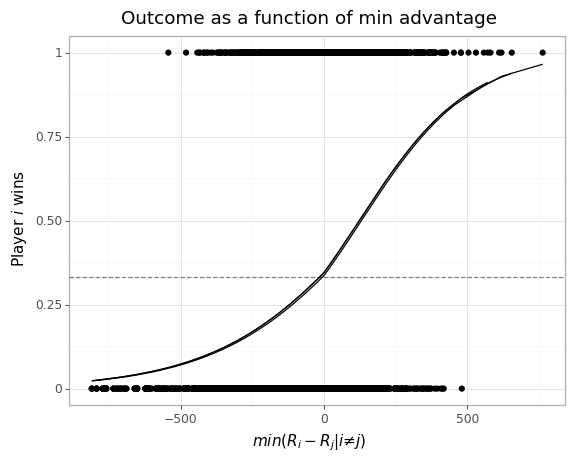

In [28]:
(
    plotnine.ggplot(
        encoded_games_df
        .assign(max_advantage=lambda df: df.min_advantage.apply(lambda x: max(0, x)))
        .assign(fit=lambda df: model.predict(df))
    )
    + plotnine.aes(x="min_advantage", y="outcome", group="factor(seat)")
    + plotnine.geom_point()
    + plotnine.geom_line(plotnine.aes(y="fit"))
    + plotnine.theme_light()
    + plotnine.geom_hline(yintercept=1./3., linetype="dashed", alpha=0.5)
    + plotnine.labs(
        title="Outcome as a function of min advantage",
        x=r"$min({R_i-R_j | i\ne j})$",
        y="Player $i$ wins"
    )
).draw();

**Figure** - Probability of winning as a function of minimum rating advantage, where $R_i$ is player $i$'s estimated rating, where we set the maximum advantage to max(0, min_advantage). The dashed horizontal line shows the no-information expected value of winning a match (1/3). We see that the model's prediction for the win probability at 0 minimum rating advantage is close to the no-information expected win probability.

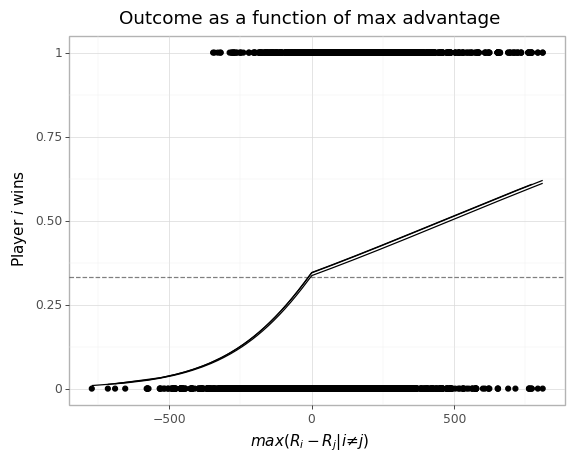

In [29]:
(
    plotnine.ggplot(
        encoded_games_df
        .assign(min_advantage=lambda df: df.max_advantage.apply(lambda x: min(0, x)))
        .assign(fit=lambda df: model.predict(df))
    )
    + plotnine.aes(x="max_advantage", y="outcome", group="factor(seat)")
    + plotnine.geom_point()
    + plotnine.geom_line(plotnine.aes(y="fit"))
    + plotnine.theme_light()
    + plotnine.geom_hline(yintercept=1./3., linetype="dashed", alpha=0.5)
    + plotnine.labs(
        title="Outcome as a function of max advantage",
        x=r"$max({R_i-R_j | i\ne j})$",
        y="Player $i$ wins"
    )
).draw();

**Figure** - Probability of winning as a function of maximum rating advantage, where $R_i$ is player $i$'s estimated rating, where we set the minimum advantage to min(0, max_advantage). The dashed horizontal line shows the no-information expected value of winning a match (1/3). We see that the model's prediction for the win probability at 0 minimum rating advantage is close to the no-information expected win probability.